In [9]:
from pymatgen.ext.matproj import MPRester
from pymatgen.electronic_structure import bandstructure as bs
from pymatgen.electronic_structure import plotter as pl
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import hbar

In [10]:
with MPRester("ONhmO4iEQzPj6KY6Mtb87H7GfztHM7JU") as m:

    # Structure for material id
    TiNiSn = m.get_bandstructure_by_material_id("mp-924130")

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

## 1/ Bande Interdite

In [11]:
Eg = TiNiSn.get_band_gap()["energy"]
print("La bande interdite indirecte mesure :",Eg,"eV de largeur.")

La bande interdite indirecte mesure : 0.4527000000000001 eV de largeur.


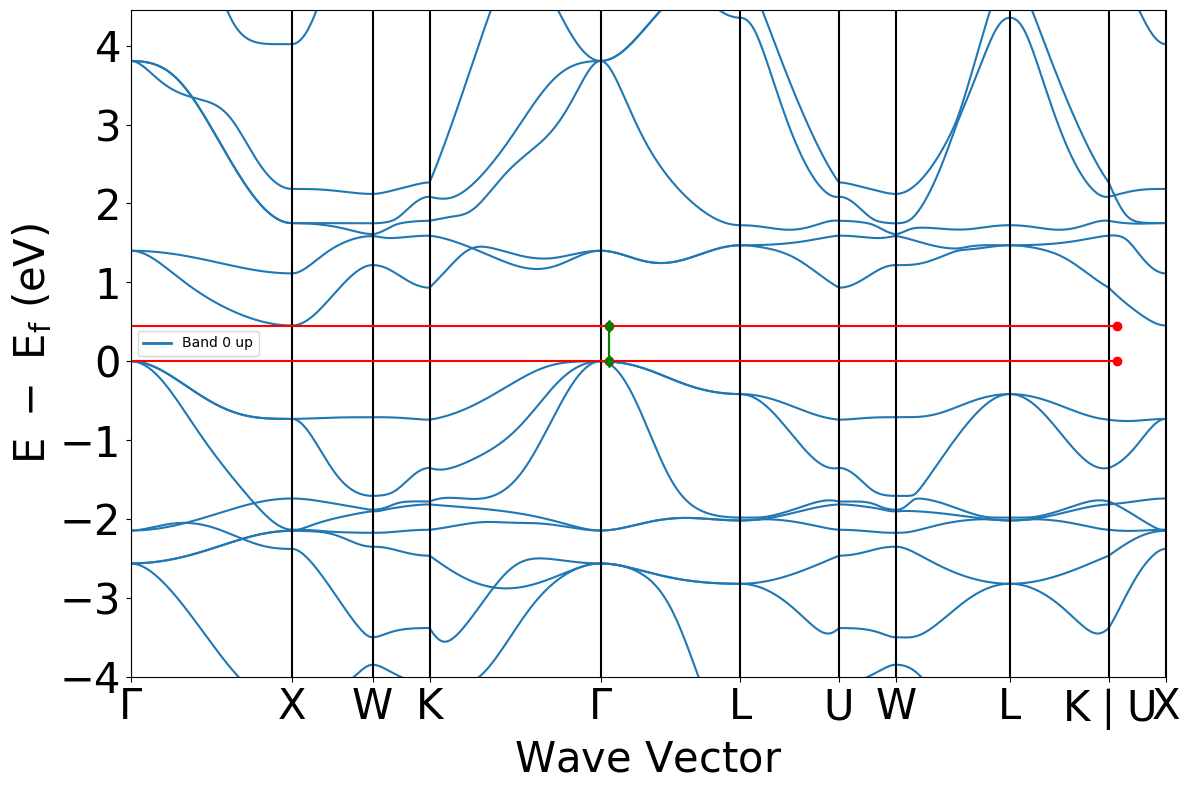

In [12]:
pl.BSPlotter(TiNiSn).get_plot()

x1, y1 = [-0.1, 6.5], [0, 0]
x2, y2 = [-0.1, 6.5], [0.4527000000000001, 0.4527000000000001]
x3, y3 = [3.15,3.15], [0,0.4527000000000001]

plt.plot(x1, y1, x2, y2,x3, y3,color = 'r', marker = 'o')
plt.plot(x3, y3, color = 'g', marker = 'd')

plt.show()

## 2/ Dispersion

Pour calculer la dispersion, on regarde la dérivée (la pente) de E par rapport à k. 

Pour ce faire on calcule delta(E)/delta(k) entre les différentes frontières de chemin pour récupèrer les minimums et maximums, ce qui nous donnera les lieux sur la bande où la dispersion est la plus petite (le minimum) et où elle est la plus grande (le maximum). 

In [13]:
data = pl.BSPlotter(TiNiSn).bs_plot_data()

dEdk_val = []
dEdk_cond = []
for i in range(len(data['distances'])) : 
    
    dk = data['distances'][i][0]-data['distances'][i][-1]
    dE_val = data["energy"]['1'][i][9][0]-data["energy"]['1'][i][9][-1] #energies["1"][numéro du chemin][numéro de la bande][indice dans la liste]
    dE_cond = data["energy"]['1'][i][10][0]-data["energy"]['1'][i][10][-1]
    
    dEdk_val.append(abs(dE_val/dk))
    dEdk_cond.append(abs(dE_cond/dk))
 
print("La direction dans laquelle la dernière bande de valence présente le plus de dispersion est de k =",
      data['distances'][dEdk_val.index(max(dEdk_val))][0],
      "1/A vers k=",data['distances'][dEdk_val.index(max(dEdk_val))][-1],"1/A")
print("Dispersion minimale pour bande de valence : de k =",data['distances'][dEdk_val.index(min(dEdk_val))][0],"1/A à",
     data['distances'][dEdk_val.index(min(dEdk_val))][-1],"1/A")
print("Dispersion maximale pour bande de conduction: de k =",data['distances'][dEdk_cond.index(max(dEdk_cond))][0],"1/A à",
     data['distances'][dEdk_cond.index(max(dEdk_cond))][-1],"1/A")
print("Dispersion minimale pour bande de conduction: de k =",data['distances'][dEdk_cond.index(min(dEdk_cond))][0],"1/A à",
     data['distances'][dEdk_cond.index(min(dEdk_cond))][-1],"1/A")

La direction dans laquelle la dernière bande de valence présente le plus de dispersion est de k = 1.0622420858586135 1/A vers k= 1.59336312878792 1/A
Dispersion minimale pour bande de valence : de k = 5.792694571130354 1/A à 6.443182344546219 1/A
Dispersion maximale pour bande de conduction: de k = 0.0 1/A à 1.0622420858586135 1/A
Dispersion minimale pour bande de conduction: de k = 1.0622420858586135 1/A à 1.59336312878792 1/A


## 3/ Masse effective

Pour trouver la masse effective, on part de l'équation suivante:

$$\frac{1}{m_*} = \frac{1}{\hbar^2}\frac{\mathrm d^2}{\mathrm d k^2} \left( E \right)$$
On peut la réécrire sous la forme :
$$m_* = \frac{\hbar^2}{\frac{\mathrm d^2}{\mathrm d k^2} \left( E \right)}$$

Pour déterminer la dérivée seconde de l'énergie, on suppose une dispersion hyperbolique. Afin d'en tirer parti, on effectue une régression polynomiale de degré 2 en prenant les valeurs de E et k au sommet de la dernière  bande de valence ou à la base de la première bande de conduction, et aux 2 points les plus proches. 

Ainsi, on a tout ce qu'il faut pour calculer la masse effective. Il suffit de prendre 2 fois le premier coefficient du polynome (résultat de la dérivée seconde), et de remettre aux bonnes unités.

In [17]:
k = [0.0]
E_cond= [data["energy"]['1'][0][10][0]]
E_val = [0.0]

for i in range(len(data['distances'])-1) :#nombre de frontières de chemin -1
    k.append(data['distances'][i][0])
    E_val.append(data["energy"]['1'][i+1][9][0]) 
    E_cond.append(data["energy"]['1'][i+1][10][0])

#print(E_valence)
#print(E_conduction)

def MasseEffective(k, E):
    poly_fit = np.polyfit(k,E, 2)
    h = 1.05371737*10**(-34)  
    return pow(h,2)/(2*poly_fit[0]*(1.602176565e-19)*10e-20) #On convertit dans les bonnes unités


Ec1=[data["energy"]['1'][1][10][-2],E_cond[2],data["energy"]['1'][2][10][1]]
Ec2=[data["energy"]['1'][7][10][-2],E_cond[8],data["energy"]['1'][8][10][1]]

kc1=[data['distances'][1][-2],data['distances'][2][0],data['distances'][2][1]]
kc2=[data['distances'][7][-2],data['distances'][8][0],data['distances'][8][1]]

Ev1=[E_val[0],data["energy"]['1'][0][9][1],data["energy"]['1'][0][9][2]]
Ev2=[data["energy"]['1'][2][9][-2],E_val[3],data["energy"]['1'][3][9][1]]

kv1=[data['distances'][0][0],data['distances'][0][1],data['distances'][0][2]] #Comme le maximum se situe à k=0, on prend ce point et les 2 suivants à droite.
kv2=[data['distances'][2][-2],data['distances'][3][0],data['distances'][3][1]]


print("\nLes masses effectives aux sommets de la dernière bande de valence valent : m* =",MasseEffective(kv1,Ev1),
      "kg pour le premier sommet et m*=",MasseEffective(kv2,Ev2), "kg pour le second.")
print("\nLes masses effectives aux bases de la dernière bande de conduction valent : m* =",MasseEffective(kc1,Ec1),
      "kg pour la première base et m*=",MasseEffective(kc2,Ec2), "kg pour la seconde.\n")


Les masses effectives aux sommets de la dernière bande de valence valent : m* = 3.323430236398727e-36 kg pour le premier sommet et m*= -1.71479222819366e-31 kg pour le second.

Les masses effectives aux bases de la dernière bande de conduction valent : m* = -6.7527504307436605e-31 kg pour la première base et m*= -4.260218222737458e-20 kg pour la seconde.

